In [1]:
import os
import sys

os.chdir('..')
sys.path.append('src')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.feature_selection import chi2, mutual_info_regression, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn_genetic import GAFeatureSelectionCV
from sklearn import set_config
from utilsPlots import na_plot, plot_density_cat, plot_bars_target, plot_predictive_power, heatmap_01_plot
from utilsTransform import SumFeatureCreator, ExcludeLevels
from utilsStats import cramers_v

In [3]:
random_state = 42
random.seed(42)
np.random.seed(42)

## Objective

Kaggle competition where the goal is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly. To help you make these predictions, you're given a set of personal records recovered from the ship's damaged computer system.

## Exploratory data analysis

Data contained 8,693 samples and 14 features. `Transported` feature was considered as target.

There were 219 duplicated `Names` entries, although no `PassengerId` values were duplicated. Therefore, the dataset was assumed to be free of actual duplicates.

Missing values were found in all features except `Transported` and `PassengerId` (@fig-na). The percentages of missing values was around 2.0-2.5% and showed a random distribution (@fig-na-dist). The percentage of samples without missing values was 76%.


In [4]:
# load data
df_train = pd.read_csv('data/train.csv')

In [5]:
# number samples and features
print(f'Number of samples {df_train.shape[0]}')
print(f'Number of features {df_train.shape[1]}')

Number of samples 8693
Number of features 14


In [6]:
# view data
df_train.head().T

,0,1,2,3,4
PassengerId,0001_01,0002_01,0003_01,0003_02,0004_01
HomePlanet,Europa,Earth,Europa,Europa,Earth
CryoSleep,False,False,False,False,False
Cabin,B/0/P,F/0/S,A/0/S,A/0/S,F/1/S
Destination,TRAPPIST-1e,TRAPPIST-1e,TRAPPIST-1e,TRAPPIST-1e,TRAPPIST-1e
Age,39.0,24.0,58.0,33.0,16.0
VIP,False,False,True,False,False
RoomService,0.0,109.0,43.0,0.0,303.0
FoodCourt,0.0,9.0,3576.0,1283.0,70.0
ShoppingMall,0.0,25.0,0.0,371.0,151.0


In [7]:
# any duplicated sample?
for feature in ['PassengerId', 'Name']:
    dupl = sum(df_train[feature].duplicated())
    print(f'Number of duplicated {feature}: {dupl}')

Number of duplicated PassengerId: 0
Number of duplicated Name: 219


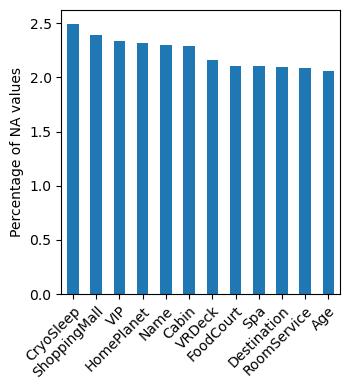

In [8]:
#| output: True
#| label: fig-na
#| fig-cap: "Percentage of missing values by feature (showing features with >30% NA values)"
na_plot(df_train)

In [9]:
print(df_train.isnull().sum().sort_values(ascending=False))

CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin           199
VRDeck          188
Spa             183
FoodCourt       183
Destination     182
RoomService     181
Age             179
PassengerId       0
Transported       0
dtype: int64


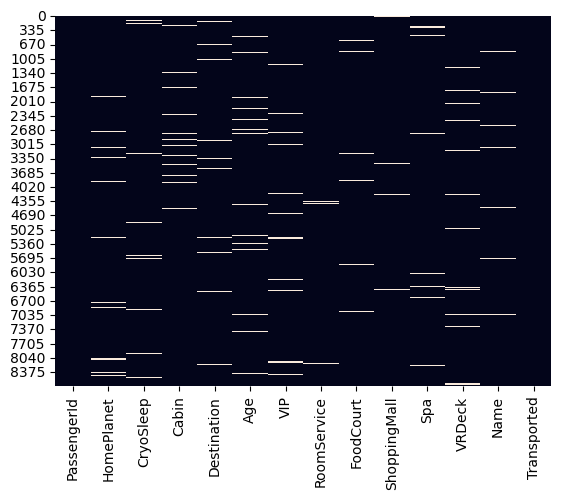

In [10]:
#| output: True
#| label: fig-na-dist
#| fig-cap: "Distribution of missing values by feature"
sns.heatmap(df_train.isna(), cbar=False)
plt.show()

In [11]:
# distribution of NA values in sample
df = df_train.drop(['PassengerId','Transported'], axis = 1)
na_perc = df.isna().sum(axis = 1)/len(df.columns)
#print('\nDistribution of NA in samples')
#print(na_perc.describe())
print(f'Percentage of samples without missing values: {sum(na_perc == 0)/df_train.shape[0]*100:.1f}%')

Percentage of samples without missing values: 76.0%


In [12]:
#df_train, df_test = train_test_split(df_train, test_size = 0.3, shuffle = True, random_state = random_state)

### Target feature.

The `Transported` feature had the following distribution: 

- True: 4378 samples.
- False: 4315 samples.

This indicates a well-balanced distribution between the two classes.

In [13]:
# distribution of target values
print(f'Number True values: {df_train["Transported"].sum()}')
print(f'Number False values: {(~df_train["Transported"]).sum()}')

Number True values: 4378
Number False values: 4315


### Features for prediction.

Some features had to be processed in a initial transformation step. The `Cabin` feature was splitted into three features: `Deck`, `Num` and `Side`, and the `Name` feature was splitted into `FirstName` and `Surname`.


In [14]:
# process Cabin feature (takes the form deck/num/side, where side can be either P for Port or S for Starboard)
df_train[['Deck','Num','Side']] = df_train['Cabin'].str.split('/', expand = True)

In [15]:
df_train[['FirstName','Surname']] = df_train['Name'].str.split(' ', expand = True)

#### Continuous quantitative

First, `Age` and `Num` features were analyzed and distributions are shown in @fig-age-num. The `Age` feature exhibits a bimodal distribution, with a small peak for very young children and a larger, more prominent peak for individuals in their early twenties. Plot suggests that younger passengers might have a lower probability of being transported. The `Num` feature's distribution is right-skewed, indicating that most samples have low values for this feature. There appears to be an inverse relationship with the target: lower values for `Num` seem to correlate with a higher probability of being transported, while higher values correlate with a lower probability.

In [16]:
# distribution feature 'Num' 
print("Num from 'Cabin' feature distribution")
print(df_train[~df_train['Num'].isna()]['Num'].astype(int).describe())
# convert to int keeping NAs
df_train['Num'] = df_train['Num'].fillna(0)
df_train['Num'] = df_train['Num'].astype(int)
df_train.loc[df_train['Num'] == 0, 'Num'] = np.nan

Num from 'Cabin' feature distribution
count    8494.000000
mean      600.367671
std       511.867226
min         0.000000
25%       167.250000
50%       427.000000
75%       999.000000
max      1894.000000
Name: Num, dtype: float64


In [17]:
print(df_train['Age'].describe())

count    8514.000000
mean       28.827930
std        14.489021
min         0.000000
25%        19.000000
50%        27.000000
75%        38.000000
max        79.000000
Name: Age, dtype: float64


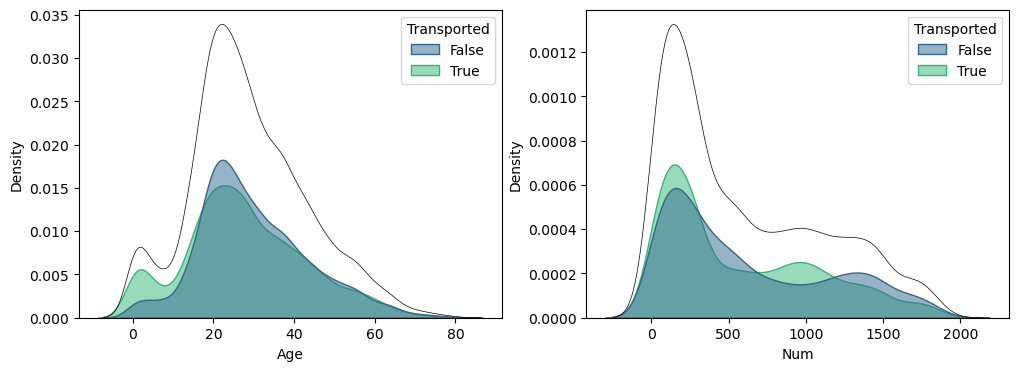

In [18]:
#| output: True
#| label: fig-age-num
#| fig-cap: "Distribution of values for Age and Num features"
plot_density_cat(df_train, ['Age', 'Num'], 'Transported', 1, 2)


Additionally, we analyzed the expense-related features. Passengers with `CryoSleep` set to `True` were excluded from this analysis, as they incurred no expenses. For improved visualization, these features were transformed using a logarithmic scale (@fig-exp)

After the transformation, all expense features exhibited a bimodal distribution, with a primary peak at the lower end and a secondary peak around a log-scale value of three. The `TotalExpenses` feature was the exception; while it also showed a bimodal pattern, its more prominent peak was the one centered at the higher value.

Passengers who spent more on `RoomService`, `Spa`, and `VRDeck` had a lower probability of being transported. This suggests a negative correlation between spending on these luxury services and the transportation outcome.


In [19]:
# visualize 'RoomService', 'FoodCourt', 'ShoppingMail', 'Spa' and 'VRDeck' and new feature 'TotalExpenses'
expense_features = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','TotalExpenses']
# calculate TotalExpenses features
df_train['TotalExpenses'] = df_train[expense_features[:-1]].sum(axis=1)
# remove samples with CryoSleep True (expenses equal to zero)
df = df_train[df_train['CryoSleep'] == False][expense_features + ['Transported']]
print(df.describe())

        RoomService     FoodCourt  ShoppingMall           Spa        VRDeck  \
count   5328.000000   5329.000000   5335.000000   5326.000000   5320.000000   
mean     350.146772    713.004316    270.586504    486.092940    475.716165   
std      803.080320   1970.547985    741.756155   1396.233751   1404.174304   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        3.000000      5.000000      2.000000      7.000000      4.000000   
75%      390.250000    537.000000    242.000000    354.750000    356.000000   
max    14327.000000  29813.000000  23492.000000  22408.000000  24133.000000   

       TotalExpenses  
count    5439.000000  
mean     2248.299687  
std      3245.061489  
min         0.000000  
25%       746.000000  
50%      1019.000000  
75%      2416.000000  
max     35987.000000  


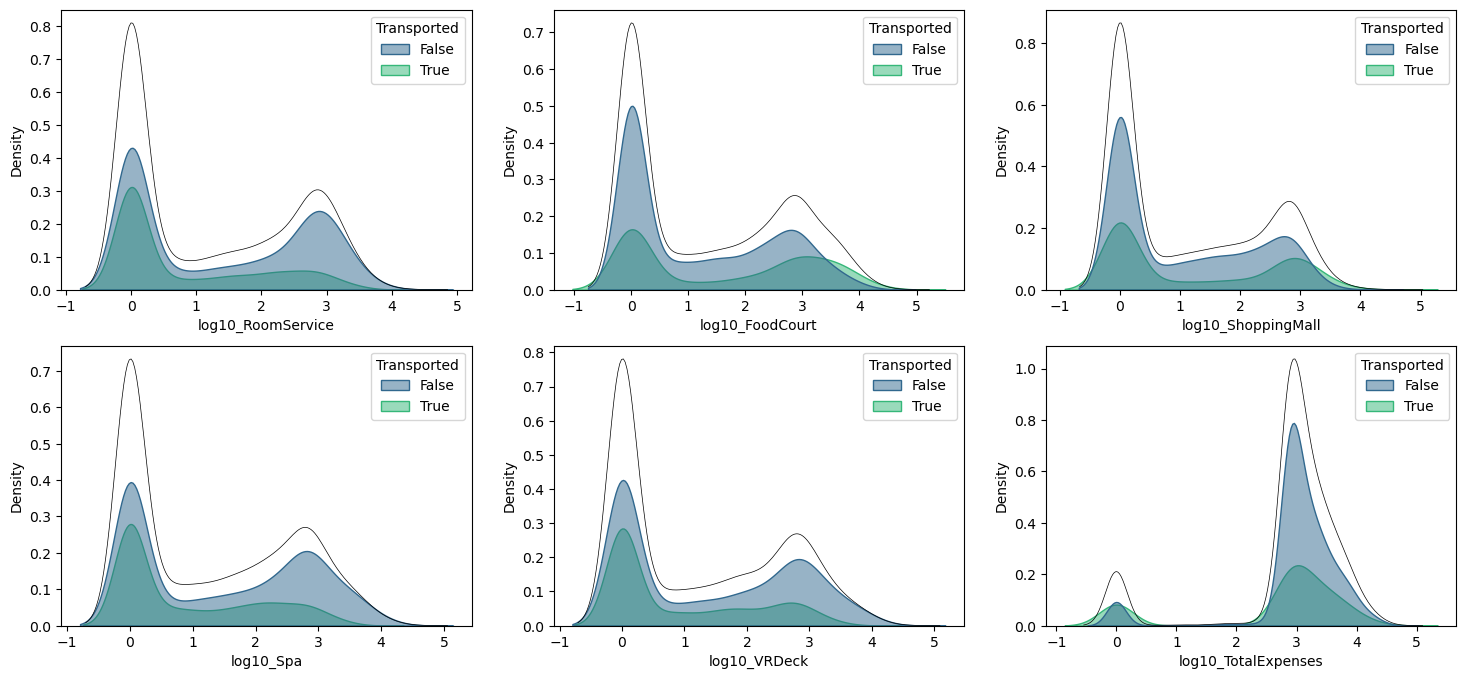

In [20]:
#| output: True
#| label: fig-exp
#| fig-cap: "Distribution of values for features related to expenses"
# visualize 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa' and 'VRDeck' and new feature 'TotalExpenses' applying log10
expense_features_log10 = list(map(lambda x: 'log10_' + x, expense_features))
# apply log10
df_train[expense_features_log10] = df_train[expense_features].apply(lambda x: np.log10(x + 1))
# remove samples with CryoSleep True (expenses equal to zero)
df = df_train[df_train['CryoSleep'] == False][expense_features_log10 + ['Transported']]
plot_density_cat(df, expense_features_log10, 'Transported', 2, 3)

#### Categorical 

The distributions for the categorical features are shown in @fig-cat. Most features have a clear majority class; for example, `Earth` is the most common `HomePlanet`, and `TRAPPIST-1e` is the most frequent `Destination`. For the `Deck` feature, decks `F` and `G` are the most populated.

A strong relationship with the outcome is also evident. Passengers in `CryoSleep` are significantly more likely to be transported. A similar positive correlation is observed for passengers on decks `B` and `C`, who also have a higher transportation rate.

The `Name` and `Surname` features contain 2,707 and 2,218 unique values, respectively.

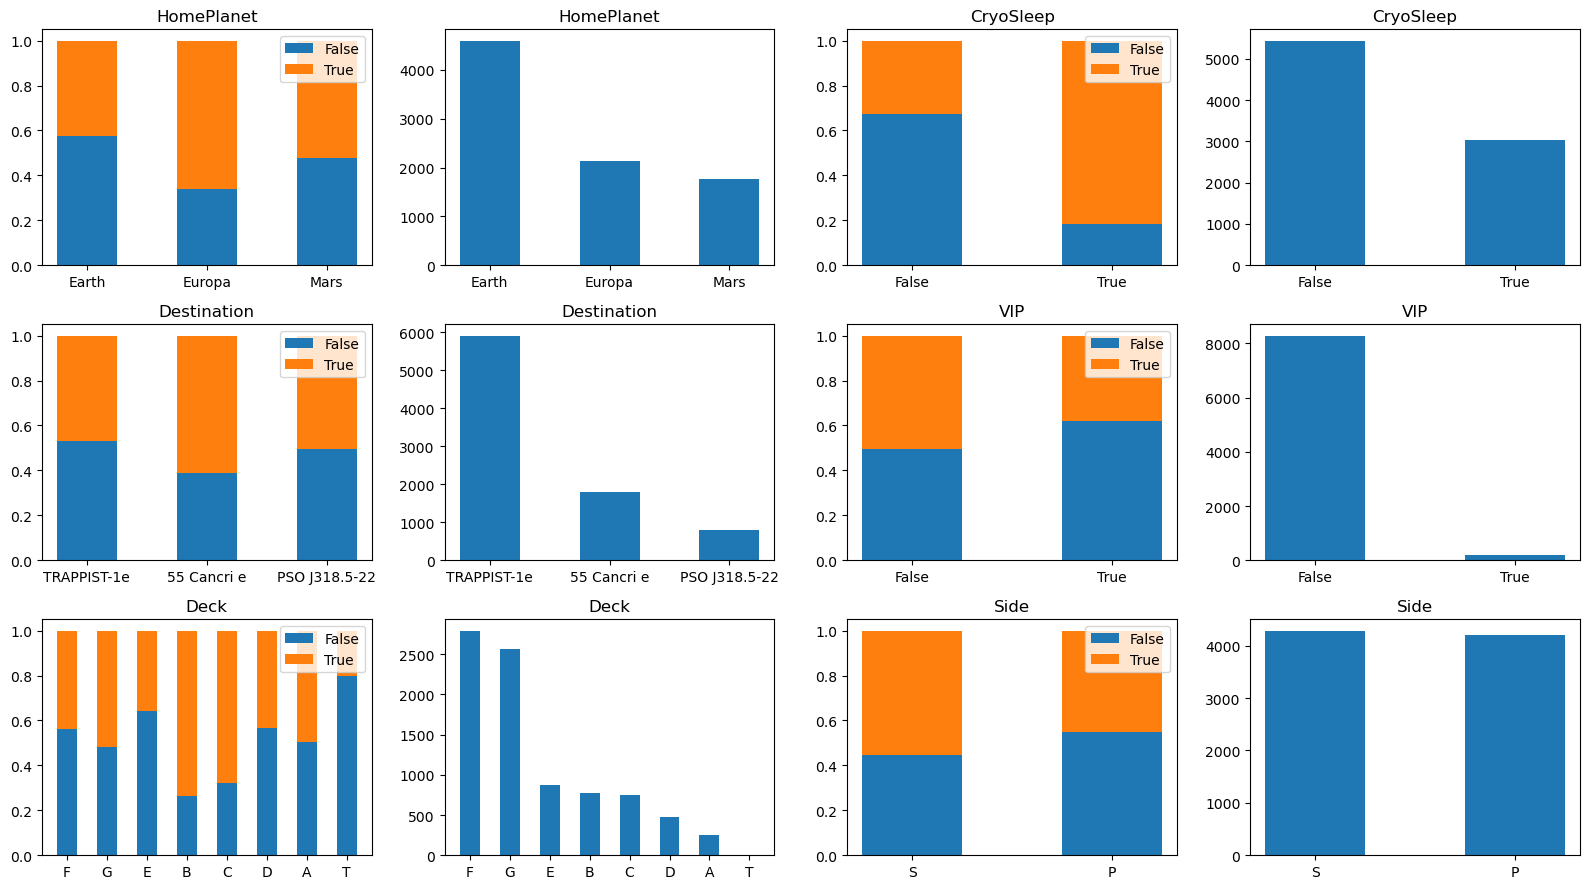

In [21]:
#| output: True
#| label: fig-cat
#| fig-cap: "Distribution of categorical features"
cat_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side']
plot_bars_target(df_train, cat_features , 'Transported', 3, 2, sort = True)

In [22]:
print(f'Number of different names: {df_train["FirstName"].unique().shape[0]}')
print(f'Number of different surnames: {df_train["Surname"].unique().shape[0]}')

Number of different names: 2707
Number of different surnames: 2218


### Feature enginering

In this step, the features were prepared for model input by applying missing value imputation, scaling, and encoding. For numerical features, the median was used for imputation, while the most frequent value was used for categorical features. Expense-related features were imputed with zero for passengers in `CryoSleep`. Additionally, new features were engineered. For instance, `TotalExpenses` was created by summing all expense-related features. Other features were derived from the `Deck` feature by grouping some of its classes.

Finally, 25 features were prepared for predictive power analysis and optimal feature selection.


In [23]:
# load data
df_train = pd.read_csv('data/train.csv')

In [24]:
# Feature preproccessing
df_train[['Deck','Num','Side']] = df_train['Cabin'].str.split('/', expand = True)
df_train[['FirstName','Surname']] = df_train['Name'].str.split(' ', expand = True)
df_train.loc[~df_train['CryoSleep'].isna() & df_train['CryoSleep'], ['ShoppingMall', 'VRDeck', 'RoomService', 'FoodCourt']] = 0

In [25]:
# Feature engineering
set_config(transform_output="pandas")

expenses = ['ShoppingMall', 'VRDeck', 'RoomService', 'FoodCourt' ]
num = ['Age'] + expenses

pipeline1 = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('create_sum', SumFeatureCreator(features_to_sum = expenses, new_feature_name = 'TotalExpenses')),
    ('scaler', StandardScaler())
])

cat = ['CryoSleep','HomePlanet', 'Destination', 'VIP', 'Deck', 'Side']
pipeline2 = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehotencoder', OneHotEncoder(sparse_output=False, drop='if_binary'))
])

pipeline3 = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('exclude_cef', ExcludeLevels(excluded = ['C', 'E', 'F'])),
])

pipeline4 = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('exclude_bcef', ExcludeLevels(excluded = ['B','C', 'E', 'F'])),
])

proc = ColumnTransformer(
    transformers = [
        ('scaled', pipeline1, num),
        ('OHE', pipeline2, cat),
        ('exclude_cef', pipeline3, ['Deck']),
        ('exclude_bcef', pipeline4, ['Deck'])
    ]
)

df_proc = proc.fit_transform(df_train)
df_proc.index = df_train.index

In [32]:
print(f"Number of features: {df_proc.shape[1]}")

Number of features: 25


### Predictive power of each feature

Mutual information analysis of the features (@fig-mi-features) shows that expense-related features and `CryoSleep` have the most significant predictive power. They are followed by features created by one hot enconding from `HomePlanet`, `Deck`, and `Destination`.


In [26]:
feature_names_out = proc.get_feature_names_out()
features_regression = list(filter(lambda x: 'scaled' in x ,list(feature_names_out)))
features_classif = list(filter(lambda x: any(s in x for s in ['OHE', 'exclude']),list(feature_names_out)))

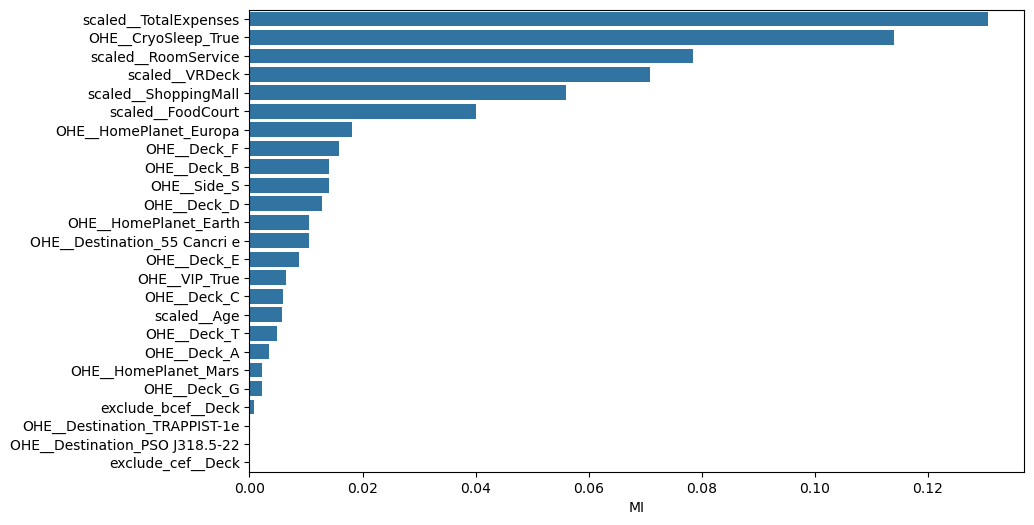

In [27]:
#| output: True
#| label: fig-mi-features
#| fig-cap: "Mutual information of features"
# plot mutual information for features (most predictive power)
X = df_proc
y = df_train['Transported']
mi_scores = mutual_info_classif(X, y).tolist()
df_mi = pd.DataFrame({'Feature': X.columns, 'Score': mi_scores}).sort_values('Score', ascending = False)
plot_predictive_power(df_mi, 'MI')

To analyze the relationships between numerical features, a Pearson correlation matrix was computed (@fig-features-corr). High correlations were observed between `TotalExpenses` and the individual expense-related features. The strongest of these correlations were with `FoodCourt` and `VRDeck`.

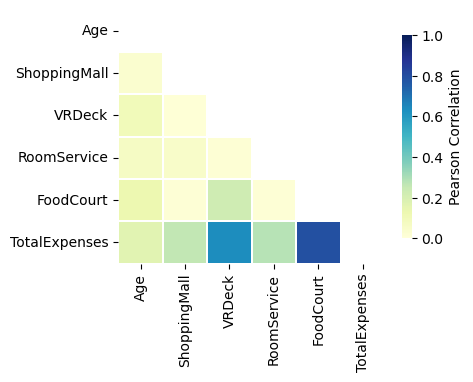

In [28]:
#| output: True
#| label: fig-features-corr
#| fig-cap: "Pearson correlation between features"
# numerical features

df = df_proc.copy()
df = df[features_regression]
df.columns = list(map(lambda x: x.replace('scaled__', ''),list(df.columns)))

# Compute the correlation matrix
corr = np.abs(df.corr())

heatmap_01_plot(corr, triangle = True, label = "Pearson Correlation")

A similar analysis was conducted for categorical features using Cramer's V to evaluate their associations (@fig-features-cramer). The strongest relationships were observed among features derived from the same source variable, such as those based on `Destination`, `HomePlanet`, and `Deck`.

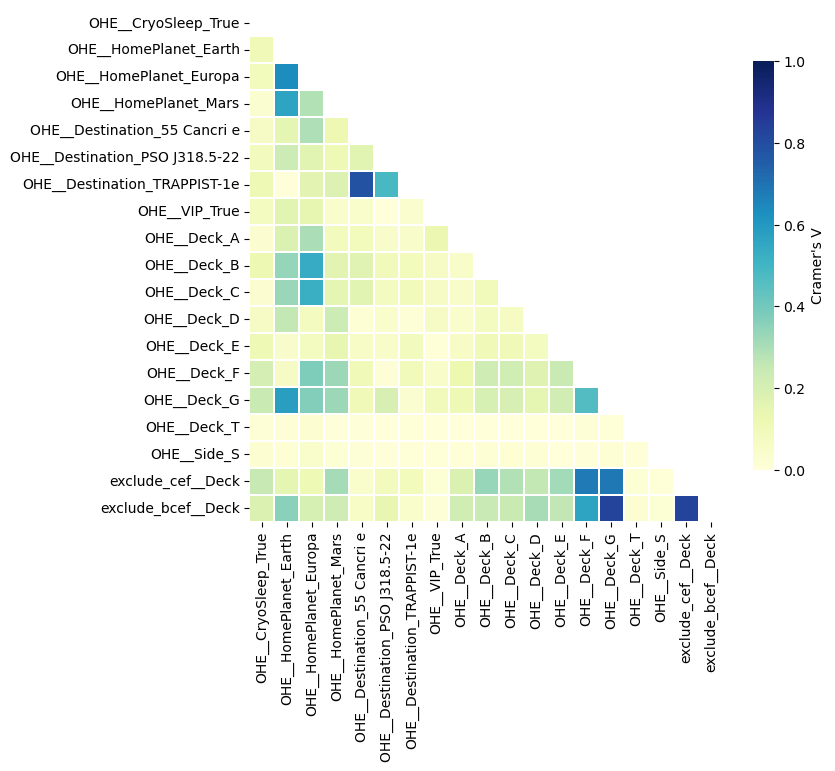

In [ ]:
#| output: True
#| label: fig-features-cramer
#| fig-cap: "Cramer's V for categorical features"
# relationship between categorical features (Cramer's V test)

scores = []
for feature1 in features_classif:
    score_feature = []
    for feature2 in features_classif:
        score_feature.append(cramers_v(df_proc[feature1], df_proc[feature2]))
    scores.append(score_feature)

cramer = pd.DataFrame(scores, columns = features_classif, index = features_classif)

heatmap_01_plot(cramer, triangle = True, label = "Cramer's V")

Finally, mutual information between all the features was calculated (@fig-matrix-mi). Same strong relationships mentioned above were observed, being clearer the relationship between `TotalExpenses` and the individual expense-related features. a new strong relationship was observed between `CryoSleep` and `TotalExpenses`.

In [ ]:
# build MI matrix

scores = {}
scores['feature1'] = []
scores['feature2'] = []
scores['score'] = []

# features for regression
for feature1 in features_regression:
    X = df_proc
    y = df_proc[feature1]
    mi = mutual_info_regression(X, y).tolist()
    for feature2, score in zip(X.columns, mi):
        scores['feature1'].append(feature1)
        scores['feature2'].append(feature2)
        scores['score'].append(score)

# features for classif
for feature1 in features_classif:
    X = df_proc
    y = df_proc[feature1]
    mi = mutual_info_classif(X, y).tolist()
    for feature2, score in zip(X.columns, mi):
        scores['feature1'].append(feature1)
        scores['feature2'].append(feature2)
        scores['score'].append(score)

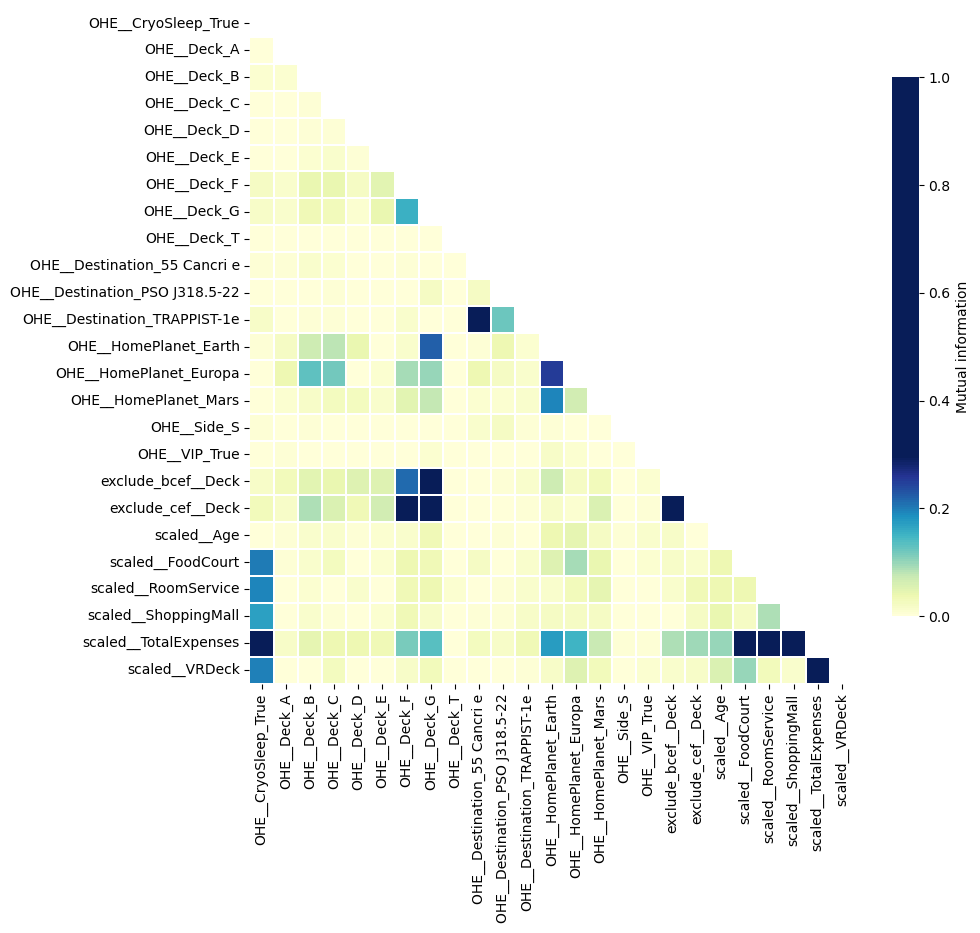

In [49]:
#| output: True
#| label: fig-matrix-mi
#| fig-cap: "Mutual information matrix"
df_scores = pd.DataFrame(scores).sort_values(['feature1','feature2'])
df_scores_heatmap = df_scores.pivot(index = 'feature1', columns = 'feature2', values = 'score')
heatmap_01_plot(df_scores_heatmap, triangle = True, threshold = 0.3, label = "Mutual information")

#### Optimal subset of features.

From the initial set of twenty-five features, an optimal subset was identified using a genetic algorithm. A linear regression model was employed to evaluate each candidate subset, and the process concluded with the selection of fifteen features.


In [29]:
#  Optimal subset of features

# Define features
X = df_proc
y = df_train['Transported']
all_feature_names = X.columns

# Use a simple Linear Regression model as the base estimator
estimator = LinearRegression()

# Configure the Genetic Algorithm
evolved_selector = GAFeatureSelectionCV(
    estimator=estimator,
    cv=5,
    scoring='neg_root_mean_squared_error',         # Metric to maximize (the fitness function)
    population_size=20,         # Number of individuals (feature subsets) in each generation
    generations=20,             # Number of times the GA will iterate
    crossover_probability=0.8,        # Probability of combining two parents
    mutation_probability=0.1,         # Probability of flipping a feature bit (0->1 or 1->0)
    n_jobs=-1,                  # Use all available CPU cores for evaluation
    verbose=True,             
    keep_top_k=3,               # Keep the top 3 individuals from generation to generation (elitism)
)

# --- Run the Optimization ---
# The .fit() method runs the full Genetic Algorithm process
print("\n--- Starting GA Feature Selection (This may take a minute) ---")
evolved_selector.fit(X, y) 
print("--- GA Feature Selection Complete ---")

# Get the mask of the best features found
best_feature_mask = evolved_selector.support_
# Get the indices of the selected features
selected_indices = np.where(best_feature_mask)[0] 
# Get the names of the selected features
selected_features = [all_feature_names[i] for i in selected_indices]

print("\n## 🏆 Best Features Found")
print(f"Number of features selected: {len(selected_indices)}")
print(f"Selected features: {selected_features}")


--- Starting GA Feature Selection (This may take a minute) ---


gen	nevals	fitness  	fitness_std	fitness_max	fitness_min
0  	20    	-0.453243	0.0145699  	-0.424804  	-0.471878  
1  	37    	-0.440723	0.0119567  	-0.424804  	-0.460629  
2  	36    	-0.430486	0.00374653 	-0.424804  	-0.436611  
3  	37    	-0.426774	0.00273961 	-0.422925  	-0.431951  
4  	37    	-0.425068	0.00198199 	-0.422579  	-0.429294  
5  	35    	-0.422676	0.00152727 	-0.417058  	-0.424907  
6  	36    	-0.420977	0.00233124 	-0.417058  	-0.422873  
7  	37    	-0.419093	0.00223624 	-0.416801  	-0.422466  
8  	37    	-0.417261	0.000423829	-0.416656  	-0.418237  
9  	35    	-0.416947	0.000380666	-0.41617   	-0.417928  
10 	34    	-0.416641	0.000348191	-0.41597   	-0.417214  
11 	38    	-0.416391	0.000315769	-0.415591  	-0.416765  
12 	36    	-0.416177	0.000351798	-0.415591  	-0.41671   
13 	34    	-0.415829	0.000129329	-0.415591  	-0.415966  
14 	39    	-0.415804	0.000114882	-0.415587  	-0.41598   
15 	36    	-0.415665	0.000114637	-0.415587  	-0.415858  
16 	35    	-0.415602	5.10318e-0